In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import seaborn as sn
import statsmodels.formula.api as smf
from IPython.display import Image

plt.style.use('ggplot')

# MARTINI - Process Swedish river data

This notebook generates a dataset of riverine inputs to Skagerrak from 5 major Swedish rivers. It builds upon the data exploration originally described in [this notebook](http://nbviewer.jupyter.org/github/JamesSample/martini/blob/master/notebooks/water_chem.ipynb). The aim is to generate a complete dataset of daily nutrient concentrations covering the period from 2015 to 2017 inclusive. The following parameters are of interest: NH4, NO3, TON, Tot-N, SRP, TOP, Tot-P, DOC and TOC. These basic quantities can then be further subdived according to the requirements of the marine model.

The workflow closely follows that used for the Norwegian data - see [this notebook](http://nbviewer.jupyter.org/github/JamesSample/martini/blob/master/notebooks/process_norway_chem.ipynb) for details.

## 1. List Swedish rivers

In [3]:
# Read Andre's list of rivers
riv_xlsx = r'../../../andre_river_data/andre_martini_rivers_jes.xlsx'
riv_df = pd.read_excel(riv_xlsx, sheet_name='rivers')

# Filter to Sweden
riv_df = riv_df.loc[riv_df['martini_code'].str.startswith('s')]

riv_df

,martini_id,station_name,resa_id,vannmiljo_id,lat,lon,martini_code
36,1,Göta Älv,NaN,NaN,57.6896,11.8974,smca108
37,2,Göta Älv Kungälv,NaN,NaN,57.7947,11.8386,smca108
38,3,Bäveån,NaN,NaN,58.3445,11.9107,smca109
39,4,Örekilsälven,NaN,NaN,58.4377,11.6832,smca110
40,5,Strömsån,NaN,NaN,58.9395,11.1700,smca111
41,6,Enningdalsälven,NaN,NaN,58.9818,11.4742,smca112


## 2. Read tidied discharge and chemistry data

The code below reads the tidied data for Sweden created in the exploratory notebook.

In [4]:
# Read tidied Swedish chem data from csv
csv_path = r'../tidied_data_series/martini_sweden_chem_tidy.csv'
wc_df = pd.read_csv(csv_path)

# Convert dates ignoring times
wc_df['sample_date'] = pd.to_datetime(wc_df['sample_date'])

# Read flows
csv_path = r'../tidied_data_series/martini_sweden_flow_tidy.csv'
swe_q_df = pd.read_csv(csv_path)

# Convert dates ignoring times
swe_q_df['date'] = pd.to_datetime(swe_q_df['date'], format='%Y-%m-%d')

## 3. Concentration-discharge relationships

### 3.1. Regression relationships

The regression model and bias correction factors used in the code below are described in [Section 3 of the Norwegian notebook](http://nbviewer.jupyter.org/github/JamesSample/martini/blob/master/notebooks/process_norway_chem.ipynb#3.-Concentration-discharge-relationships).

In [5]:
# Simple OLS regression against flow
reg_dict = {}
for mvm_id in wc_df['mvm_id'].unique():
    # Get stn data
    df = wc_df.query('mvm_id == @mvm_id')

    # Get flow data 
    q_df = swe_q_df.query('mvm_id == @mvm_id').copy()
    q_df.set_index('date', inplace=True)
    del q_df['mvm_id']    
    
    # Restructure chem
    df = df.sort_values(['sample_date', 'par_unit'])
    idx_cols = ['mvm_id', 'station_name', 'lon', 'lat', 'sample_date', 'par_unit']
    df.set_index(idx_cols, inplace=True)
    df = df.unstack('par_unit').reset_index().sort_values('sample_date')
    df.index = df['sample_date']
    del df['mvm_id'], df['station_name'], df['lon'], df['lat'], df['sample_date']
    df.columns = df.columns.get_level_values(1)

    # Get list of chem cols
    if mvm_id == 42954:
        # No TOC
        chem_cols = ['N-TOT_µg/l', 'P-TOT_µg/l']
    else:
        chem_cols = ['N-TOT_µg/l', 'P-TOT_µg/l', 'TOC_mg/l']

    # Join to Q
    df = df.join(q_df, how='left')

    # Get logged data (base-10)
    df2 = np.log10(df)
    df2.columns = ['log(%s)' % i for i in df2.columns]
    df = df.join(df2)

    # Regression
    for col in chem_cols:
        # OLS regression
        res = smf.ols(formula='Q("log(%s)") ~ Q("log(flow_m3/s)")' % col, data=df).fit()

        # Plot diagnotsics
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

        axes[0].plot(res.model.exog[:, 1], res.resid, 'ro')
        axes[0].set_xlabel('log[Flow (m3/s)]')
        axes[0].set_ylabel('Residual')

        sn.distplot(res.resid.values, ax=axes[1])
        axes[1].set_xlabel('Residual')

        plt.suptitle('%s at MVM ID %05d' % (col.split('_')[0], mvm_id))
        plt.tight_layout()

        # Save png
        png_path = r'../plots/flow_conc_reg_resid/mvm_id_%05d_%s.png' % (mvm_id, col.split('_')[0])
        plt.savefig(png_path, dpi=300)
        plt.close()  

        # Add to results
        reg_dict[(mvm_id, col)] = res

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


### 3.2. Calculate daily Tot-N, Tot-P and TOC

The code below uses the equations from Section 3.1 to estimate daily Tot-N, Tot-P and TOC from discharge.

In [6]:
# Loop over sites
data_dict = {}
for mvm_id in wc_df['mvm_id'].unique():
    # Get stn data
    df = wc_df.query('mvm_id == @mvm_id')

    # Restructure chem
    df = df.sort_values(['sample_date', 'par_unit'])
    df.set_index(idx_cols, inplace=True)
    df = df.unstack('par_unit').reset_index().sort_values('sample_date')
    df.index = df['sample_date']
    del df['mvm_id'], df['station_name'], df['lon'], df['lat'], df['sample_date']
    df.columns = df.columns.get_level_values(1)

    # Get flow data 
    q_df = swe_q_df.query('mvm_id == @mvm_id').copy()
    q_df.set_index('date', inplace=True)
    q_df = q_df.resample('D').mean()
    q_df.interpolate(kind='linear', inplace=True)
    q_df = q_df.truncate(before='2015-01-01', after='2017-12-31')
    del q_df['mvm_id']
    
    # Get list of chem cols
    if mvm_id == 42954:
        # No TOC
        chem_cols = ['N-TOT_µg/l', 'P-TOT_µg/l']
    else:
        chem_cols = ['N-TOT_µg/l', 'P-TOT_µg/l', 'TOC_mg/l']

    # Get just cols of interest
    df = df[chem_cols]

    # Join to Q
    df = q_df.join(df, how='left')

    # Loop over chem data
    for col in chem_cols:
        # Get regression result
        res = reg_dict[(mvm_id, col)]

        # Calc C
        concs = (10**res.params[0])*(df['flow_m3/s']**res.params[1])

        # Back-transform
        alpha = np.exp(2.651*((res.resid.values)**2).mean())
        concs = alpha*concs

        # Update series
        df[col] = concs #df[col].fillna(concs)

        # Add to results
        data_dict[mvm_id] = df

## 4. Concentration-concentration relationships

### 4.1. Regression relationships

The tables below show summary statistics for each regression. Note that **I've removed the intercept term** (unlike on the rough plots in the [exploratory notebook](http://nbviewer.jupyter.org/github/JamesSample/martini/blob/master/notebooks/water_chem.ipynb)), as it seems sensible to fix the intercept at the origin for all these models.

In [8]:
# Restructure chem
df = wc_df.copy()
df = df.sort_values(['mvm_id', 'sample_date', 'par_unit'])
df.set_index(idx_cols, inplace=True)
df = df.unstack('par_unit').reset_index().sort_values(['mvm_id', 'sample_date'])
del df['station_name'], df['lon'], df['lat']
df.columns = df.columns.get_level_values(1)
cols = list(df.columns)
cols[:2] = ['mvm_id', 'sample_date']
df.columns = cols

### 4.1.1. NH4 vs. Tot-N

$R^2 \approx 52\%$

$p \approx 0$

$NH_4 \approx 0.054*TotN$

In [9]:
# NH4
nh4_reg = smf.ols(formula='Q("N-NH4_µg/l") ~ Q("N-TOT_µg/l") - 1', data=df).fit()
print(nh4_reg.summary())

                            OLS Regression Results                            
Dep. Variable:        Q("N-NH4_µg/l")   R-squared:                       0.520
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     1089.
Date:                Tue, 18 Dec 2018   Prob (F-statistic):          2.10e-162
Time:                        13:24:02   Log-Likelihood:                -5079.3
No. Observations:                1007   AIC:                         1.016e+04
Df Residuals:                    1006   BIC:                         1.017e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Q("N-TOT_µg/l")     0.0541      0.002     

### 4.1.2. NO3 vs. Tot-N

$R^2 \approx 87\%$

$p \approx 0$

$NO_3 \approx 0.45*TotN$

In [10]:
# NO3
no3_reg = smf.ols(formula='Q("N-NO3_µg/l") ~ Q("N-TOT_µg/l") - 1', data=df).fit()
print(no3_reg.summary())

                            OLS Regression Results                            
Dep. Variable:        Q("N-NO3_µg/l")   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     6637.
Date:                Tue, 18 Dec 2018   Prob (F-statistic):               0.00
Time:                        13:24:51   Log-Likelihood:                -6303.7
No. Observations:                1007   AIC:                         1.261e+04
Df Residuals:                    1006   BIC:                         1.261e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Q("N-TOT_µg/l")     0.4510      0.006     

### 4.1.3. SRP vs. Tot-P

$R^2 \approx 73\%$

$p \approx 0$

$SRP \approx 0.32*TotP$

In [11]:
srp_reg = smf.ols(formula='Q("SRP_µg/l") ~ Q("P-TOT_µg/l") - 1', data=df).fit()
print(srp_reg.summary())

                            OLS Regression Results                            
Dep. Variable:          Q("SRP_µg/l")   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     2710.
Date:                Tue, 18 Dec 2018   Prob (F-statistic):          1.39e-287
Time:                        13:25:30   Log-Likelihood:                -3286.8
No. Observations:                1006   AIC:                             6576.
Df Residuals:                    1005   BIC:                             6581.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Q("P-TOT_µg/l")     0.3210      0.006     

### 4.1.4. DOC vs. TOC

There is no DOC data for the Swedish sites, so I'll use the same regression results as in Norway:

$R^2 \approx 100\%$

$p \approx 0$

$DOC \approx 0.97*TOC$

### 4.2. Estimate NH4, NO3, SRP and DOC

In [13]:
# Loop over sites
for mvm_id in data_dict.keys():
    # Get data
    df = data_dict[mvm_id]
    
    # Calc params
    if 'N-TOT_µg/l' in df.columns:
        df['N-NH4_µg/l'] = nh4_reg.params[0]*df['N-TOT_µg/l']
        df['N-NO3_µg/l'] = no3_reg.params[0]*df['N-TOT_µg/l']
        
    if 'P-TOT_µg/l' in df.columns:
        df['SRP_µg/l'] = srp_reg.params[0]*df['P-TOT_µg/l']
        
    if 'TOC_mg/l' in df.columns:
        # Use result from Norway
        df['DOC_mg/l'] = 0.97*df['TOC_mg/l']
        
    # Update results
    data_dict[mvm_id] = df

## 5. Estimate other parameters of interest

Time series plots of the final daily series can be found [here](https://github.com/JamesSample/martini/tree/master/plots/daily_series). An illustrative example is shown below.

In [14]:
# Loop over sites
df_list = []
for mvm_id in data_dict.keys():
    # Get data
    df = data_dict[mvm_id]
    
    # Calc. TON
    df['N-TON_µg/l'] = df['N-TOT_µg/l'] - df['N-NH4_µg/l'] - df['N-NO3_µg/l']
    
    # Plot
    df.plot(subplots=True, 
            layout=(3,3), 
            figsize=(15,10),
            legend=False,
            title=list(df.columns))
    
    plt.tight_layout()

    # Save png
    png_path = r'../plots/daily_series/mvm_id_%05d.png' % mvm_id
    plt.savefig(png_path, dpi=300)
    plt.close() 
    
    # Tidy
    cols = list(df.columns)
    df.reset_index(inplace=True)
    df['mvm_id'] = mvm_id
    df = df[['mvm_id', 'date'] + cols]
    
    # Add to output
    df_list.append(df)
    
# Combine
df = pd.concat(df_list, axis=0, sort=False)

# Write output
csv_path = r'../tidied_data_series/swe_daily_water_chem.csv'
df.to_csv(csv_path, index=False, encoding='utf-8')

df.head()

,mvm_id,date,flow_m3/s,N-TOT_µg/l,P-TOT_µg/l,TOC_mg/l,N-NH4_µg/l,N-NO3_µg/l,SRP_µg/l,DOC_mg/l,N-TON_µg/l
0,31,2015-01-01,8.16,806.648654,35.340670,12.357686,43.677568,363.758608,11.345067,11.986955,399.212479
1,31,2015-01-02,14.50,842.760079,35.594649,12.636160,45.632891,380.043073,11.426599,12.257075,417.084115
2,31,2015-01-03,12.60,833.791364,35.532432,12.567554,45.147263,375.998626,11.406626,12.190527,412.645475
3,31,2015-01-04,9.89,818.550738,35.425412,12.450133,44.322029,369.125858,11.372271,12.076629,405.102850
4,31,2015-01-05,8.18,806.799090,35.341747,12.358859,43.685713,363.826447,11.345413,11.988093,399.286930


Estimated daily series for MVM ID 42954.


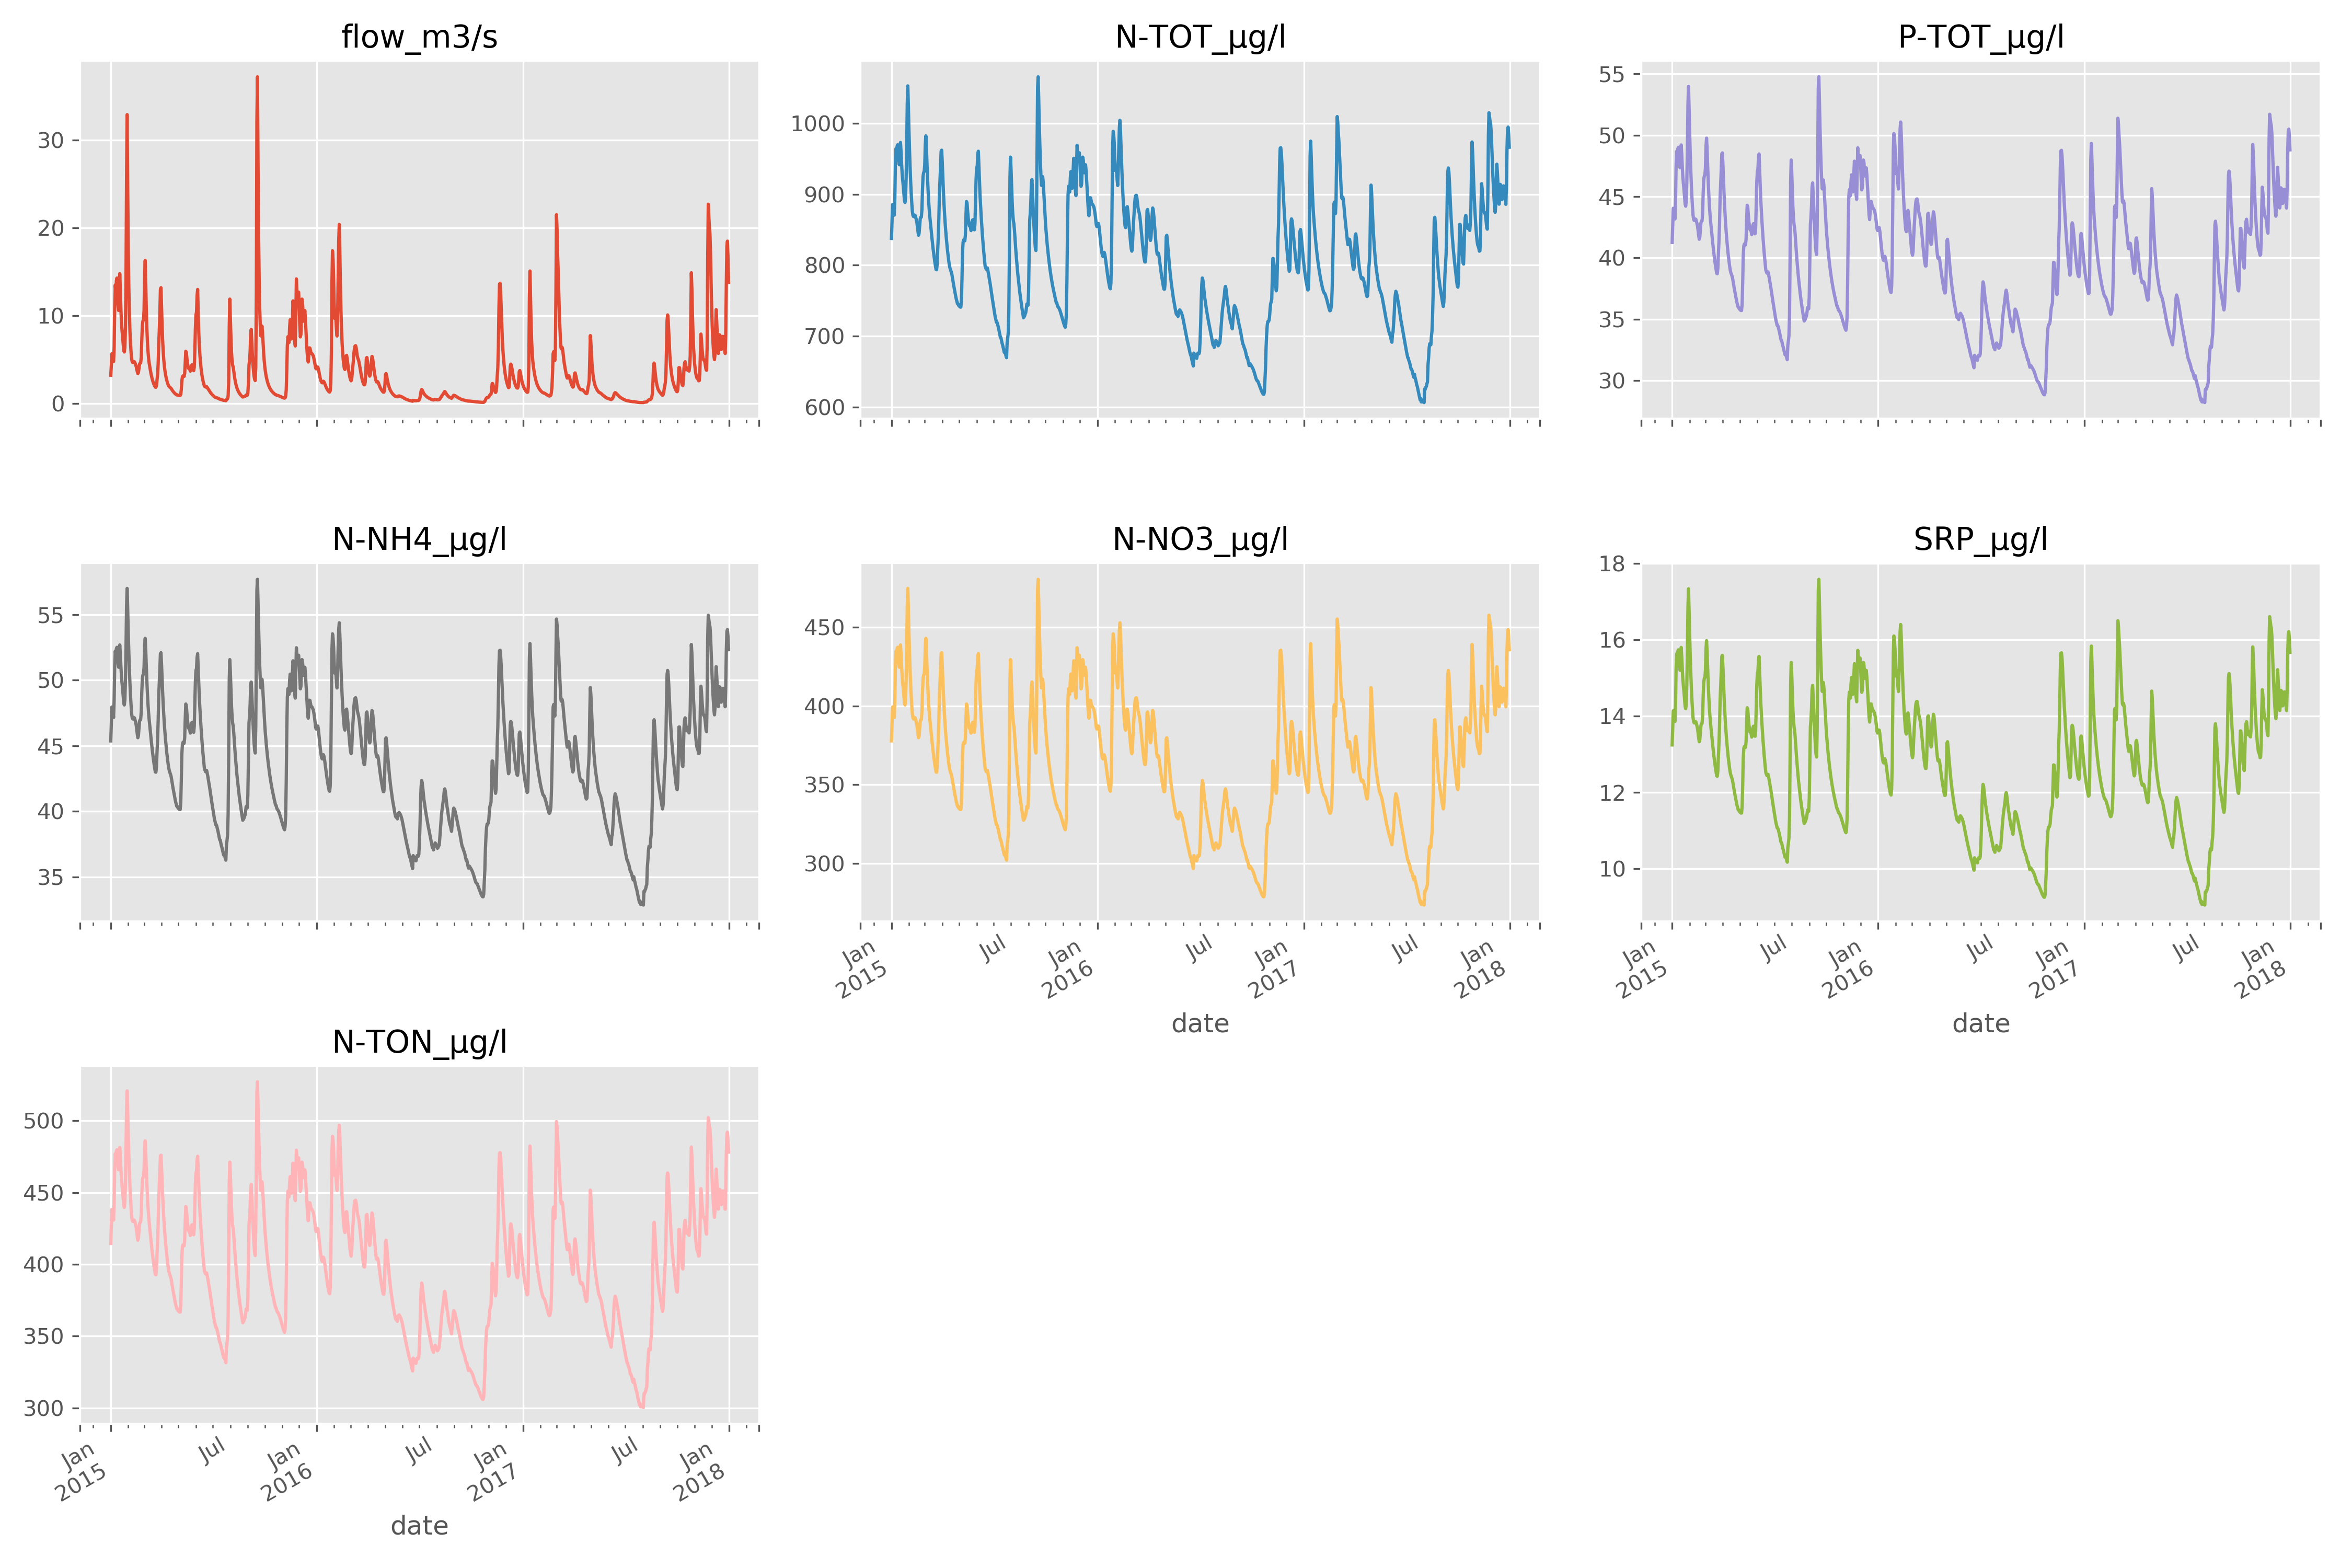

In [15]:
# Show example image
print ('Estimated daily series for MVM ID %s.' % mvm_id)
Image(png_path)